In [1]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
print(f"Rows in train.csv = {len(df_train)}")
print(f"Rows in test.csv = {len(df_test)}")
pd.set_option('display.max_colwidth', None)
df_train.head()

Rows in train.csv = 7613
Rows in test.csv = 3263


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [2]:
df_train_pos = df_train[df_train.target == 1]
df_train_neg = df_train[df_train.target == 0]
print(f"No. of positive training examples = {len(df_train_pos)}")
print(f"No. of negative training examples = {len(df_train_neg)}")
train_keywords_unique = df_train.keyword.unique()
print(f"No. of unique keywords = {len(train_keywords_unique)}")
df_train_notnull_keywords = df_train[~df_train.keyword.isnull()]
print(f"No of train examples with keyword not null = {len(df_train_notnull_keywords)}")
df_train_notnull_keywords.head()

No. of positive training examples = 3271
No. of negative training examples = 4342
No. of unique keywords = 222
No of train examples with keyword not null = 7552


,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0


In [3]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Preprocess the tweets 

In [4]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'[^\d\W]+')
#df_train['text_processed'] = [tokenizer.tokenize(item) for item in df_train['text']]
#df_test['text_processed'] = [tokenizer.tokenize(item) for item in df_test['text']]

# Perform stemming using WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")
#df_train['text_processed'] = df_train['text_processed'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
#df_test['text_processed'] = df_test['text_processed'].apply(lambda x: [stemmer.stem(y) for y in x])    

In [5]:
from common_utils import process_tweet

df_train['text_processed'] = df_train['text'].apply(lambda text: process_tweet(text))
df_train.head()

,id,keyword,location,text,target,text_processed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,"[deed, reason, earthquak, may, allah, forgiv, us]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, rong, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,"[resid, ask, shelter, place, notifi, offic, evacu, shelter, place, order, expect]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,"[13,000, peopl, receiv, wildfir, evacu, order, california]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,"[got, sent, photo, rubi, alaska, smoke, wildfir, pour, school]"


In [6]:
df_test['text_processed'] = df_test['text'].apply(lambda text: " ".join(process_tweet(text)))
df_test.head()

,id,keyword,location,text,text_processed
0,0,NaN,NaN,Just happened a terrible car crash,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond gees flee across street cannot save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


Build the frequency dictionary for positive and negative words in tweets ( positive means target value is 1 and negative means 0 )

In [7]:
# from common_utils import build_freqs
import numpy as np

def add_or_increment(key, dict):
    if key in dict:
        dict[key] += int(1)
    else:
        dict[key] = int(1)

def build_freqs(processed_tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    pos_freqs = {}
    neg_freqs = {}
    for y, tweet in zip(yslist, processed_tweets):        
        for word in tweet:
            pair = (word, y)
            add_or_increment(pair, freqs)
            if y == 1:
                add_or_increment(word, pos_freqs)
            else:
                add_or_increment(word, neg_freqs)
    return freqs, pos_freqs, neg_freqs

X_input_tweets = df_train['text_processed']
X_test_tweets = df_test['text_processed']
y_input = df_train['target']
freqs, pos_word_freqs, neg_word_freqs = build_freqs(X_input_tweets, y_input)


In [8]:
df_train_pos = df_train[df_train.target == 1]
df_train_neg = df_train[df_train.target == 0]
# keyword frequency in disaster tweets
pos_keyword_freq = df_train_pos['keyword'].value_counts()
# location frequency in disaster tweets
pos_location_freq = df_train_pos['location'].value_counts()
# keyword frequency in non disaster tweets
neg_keyword_freq = df_train_neg['keyword'].value_counts()
# location frequency in non disaster tweets
neg_location_freq = df_train_neg['location'].value_counts()

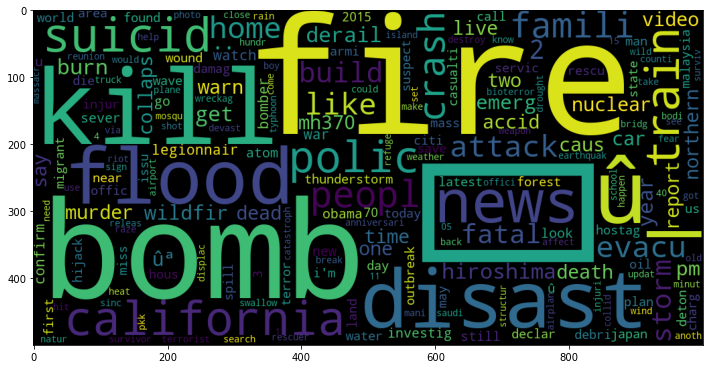

In [9]:
# Word cloud for disaster tweets
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(freq_dict):
    wc = WordCloud(width=1000, height=500).generate_from_frequencies(freq_dict)
    plt.figure(figsize=(12,8))
    plt.imshow(wc)

plot_wordcloud(pos_word_freqs)

D:\InstalledSoftware\anaconda3\envs\fastai\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\InstalledSoftware\anaconda3\envs\fastai\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


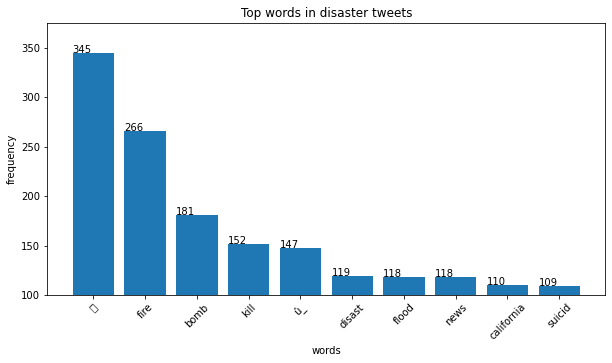

In [26]:
# plot top 10 words in disaster tweets as a bar plot
from common_utils import get_topn_dictitems_byvalue

def barplot(freq_dict, n, x_label, y_label, title, y_range = []):
    topn_keys_byvalue = get_topn_dictitems_byvalue(freq_dict, n)
    key_counts = [count for count, key in topn_keys_byvalue]
    key = [key for count, key in topn_keys_byvalue]

    fig, ax = plt.subplots(figsize=(10, 5))
    if len(y_range) > 0:
        ax.set_ylim(y_range)
    bars = ax.bar(key, key_counts)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    plt.title(title)
    plt.xticks(rotation=45)
    # add the y value on top of each bar
    for bar in bars:
        y_val = bar.get_height()
        plt.text(bar.get_x(), y_val+0.05, y_val)
    plt.show()

barplot(pos_word_freqs, 10, 'words', 'frequency', 'Top words in disaster tweets', [100, 375])

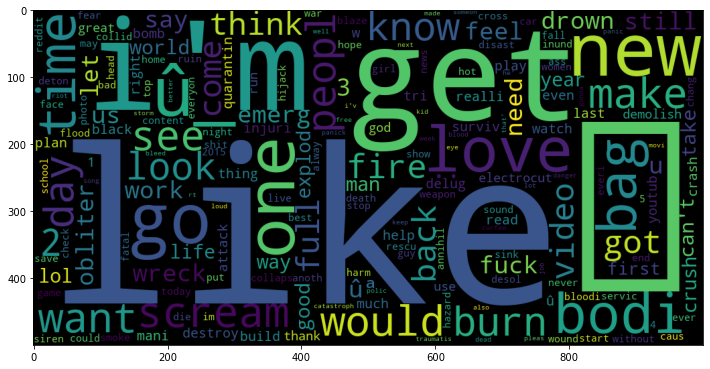

In [12]:
# plot word cloud for words in non disaster tweets
plot_wordcloud(neg_word_freqs)

D:\InstalledSoftware\anaconda3\envs\fastai\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\InstalledSoftware\anaconda3\envs\fastai\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


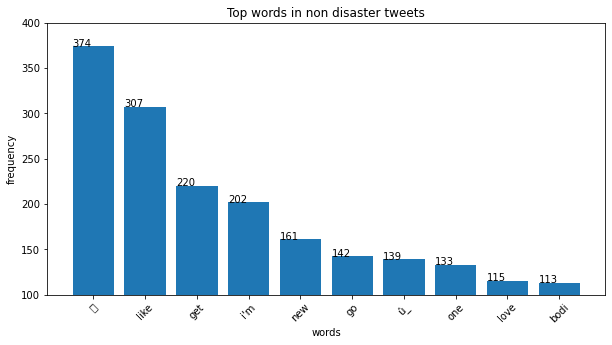

In [27]:
barplot(neg_word_freqs, 10, 'words', 'frequency', 'Top words in non disaster tweets', [100, 400])

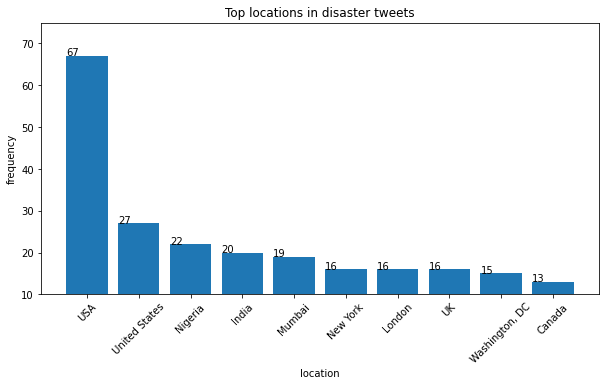

In [28]:
barplot(pos_location_freq, 10, 'location', 'frequency', 'Top locations in disaster tweets', [10, 75])

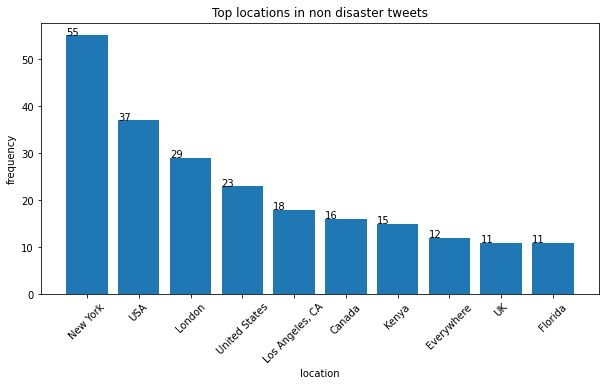

In [29]:
barplot(neg_location_freq, 10, 'location', 'frequency', 'Top locations in non disaster tweets')

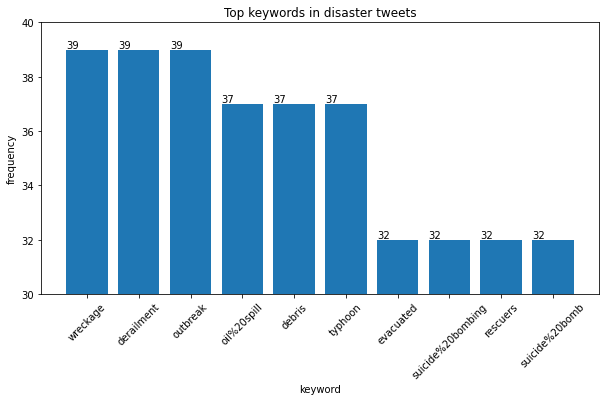

In [31]:
barplot(pos_keyword_freq, 10, 'keyword', 'frequency', 'Top keywords in disaster tweets', [30, 40])

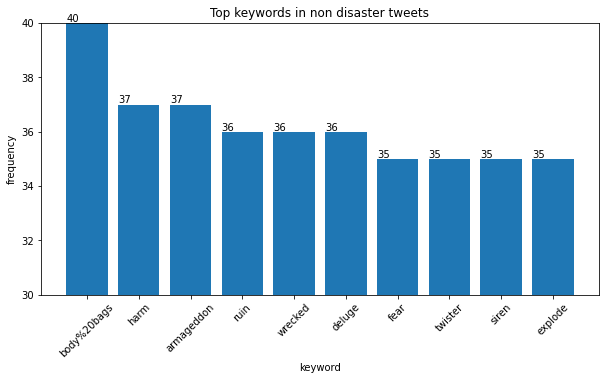

In [33]:
barplot(neg_keyword_freq, 10, 'keyword', 'frequency', 'Top keywords in non disaster tweets', [30, 40])

In [ ]:
def extract_features(tweet, keyword, loc, freqs, pos_keyword_freqs, neg_keyword_freqs, 
                    pos_loc_freqs, neg_loc_freqs):
    tweet_words = tweet
    # first column is bias, second positive word count, third negative word count
    feature_vector = np.zeros((1, 7))
    #feature_vector = np.zeros((1, 3))
    feature_vector[0, 0] = 1
    #print(f"keyword: {keyword}")
    for word in tweet_words:
        feature_vector[0, 1] += freqs.get((word, 1.0), 0)        
        feature_vector[0, 2] += freqs.get((word, 0.0), 0)
    if not pd.isnull(keyword):   
        #print(keyword)       
        if keyword in pos_keyword_freqs.keys():  
            feature_vector[0, 3] += pos_keyword_freqs[keyword]
        if keyword in neg_keyword_freqs.keys():            
            feature_vector[0, 4] += neg_keyword_freqs[keyword]
    if not pd.isnull(loc):   
        #print(keyword)       
        if loc in pos_loc_freqs.keys():  
            feature_vector[0, 5] += pos_loc_freqs[loc]
        if loc in neg_loc_freqs.keys():            
            feature_vector[0, 6] += neg_loc_freqs[loc]            
    return feature_vector

In [ ]:
X_input_keywords = df_train['keyword']

In [ ]:
test_features = extract_features(X_input_tweets[0], 'aftershock', 'usa', freqs, 
                pos_keyword_freqs, neg_keyword_freqs, pos_location_freqs, neg_location_freqs)
test_features

In [ ]:
#X_input = np.zeros((len(X_input_tweets), 5))
X_input = np.zeros((len(X_input_tweets), 7))
for i, row in df_train.iterrows():
    X_input[i, :] = extract_features(row['text_processed'], row['keyword'], row['location'], 
                            freqs, pos_keyword_freqs, neg_keyword_freqs, pos_location_freqs, neg_location_freqs)

print(X_input.shape)

#X_test = np.zeros((len(X_test_tweets), 5))
X_test = np.zeros((len(X_test_tweets), 7))
for i, row in df_test.iterrows():
    X_test[i, :] = extract_features(row['text_processed'], row['keyword'], row['location'], 
                            freqs, pos_keyword_freqs, neg_keyword_freqs, pos_location_freqs, neg_location_freqs)
    
print(X_test.shape)    

In [ ]:
input_df = pd.DataFrame(X_input)
input_df.to_csv('input.csv')

Split training data into 80% training set and 20% validation set

In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(X_input, y_input, test_size=0.2, random_state=42)
#X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
from sklearn.naive_bayes import ComplementNB
mnb = ComplementNB(alpha=1)
mnb.fit(X_input, y_input.ravel())

In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(mnb, X_input, y_input, cv=5, scoring="f1")
cv_results['test_score'].mean()

In [ ]:
#mnb.score(X_val, y_val)

In [ ]:
#y_val_pred = mnb.predict(X_val)

In [ ]:
#from sklearn.metrics import classification_report
#print(classification_report(y_val, y_val_pred))

In [ ]:
y_test_pred = mnb.predict(X_test)
df_test['target'] = y_test_pred
df_test.head(20)

In [ ]:
df_submit = df_test[['id', 'target']]
df_submit.to_csv('results.csv', index=False)

In [ ]:
df_train.to_csv('train_processed1.csv')